/tmp/ipython-input-1014962621.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download('BTC-USD', start='2022-01-01', end=datetime.now().strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed

📊 Fetching BTC data...
✅ Downloaded 1446 days of BTC data

✅ Fixed MultiIndex columns
Price              Close          High           Low          Open  \
Date                                                                 
2022-01-01  47686.812500  47827.312500  46288.484375  46311.746094   
2022-01-02  47345.218750  47881.406250  46856.937500  47680.925781   
2022-01-03  46458.117188  47510.726562  45835.964844  47343.542969   
2022-01-04  45897.574219  47406.546875  45752.464844  46458.851562   
2022-01-05  43569.003906  46929.046875  42798.222656  45899.359375   

Price            Volume  
Date                     
2022-01-01  24582667004  
2022-01-02  27951569547  
2022-01-03  33071628362  
2022-01-04  42494677905  
2022-01-05  36851084859  

Data shape: (1446, 5)

✅ After feature engineering: 1426 samples

Features used: ['Day', 'MA_7', 'MA_21', 'Lag_1', 'Lag_7', 'Volatility', 'Volume']

📈 Training samples: 1140
📉 Testing samples: 286

✅ Model trained successfully!

📊 MODEL EVA

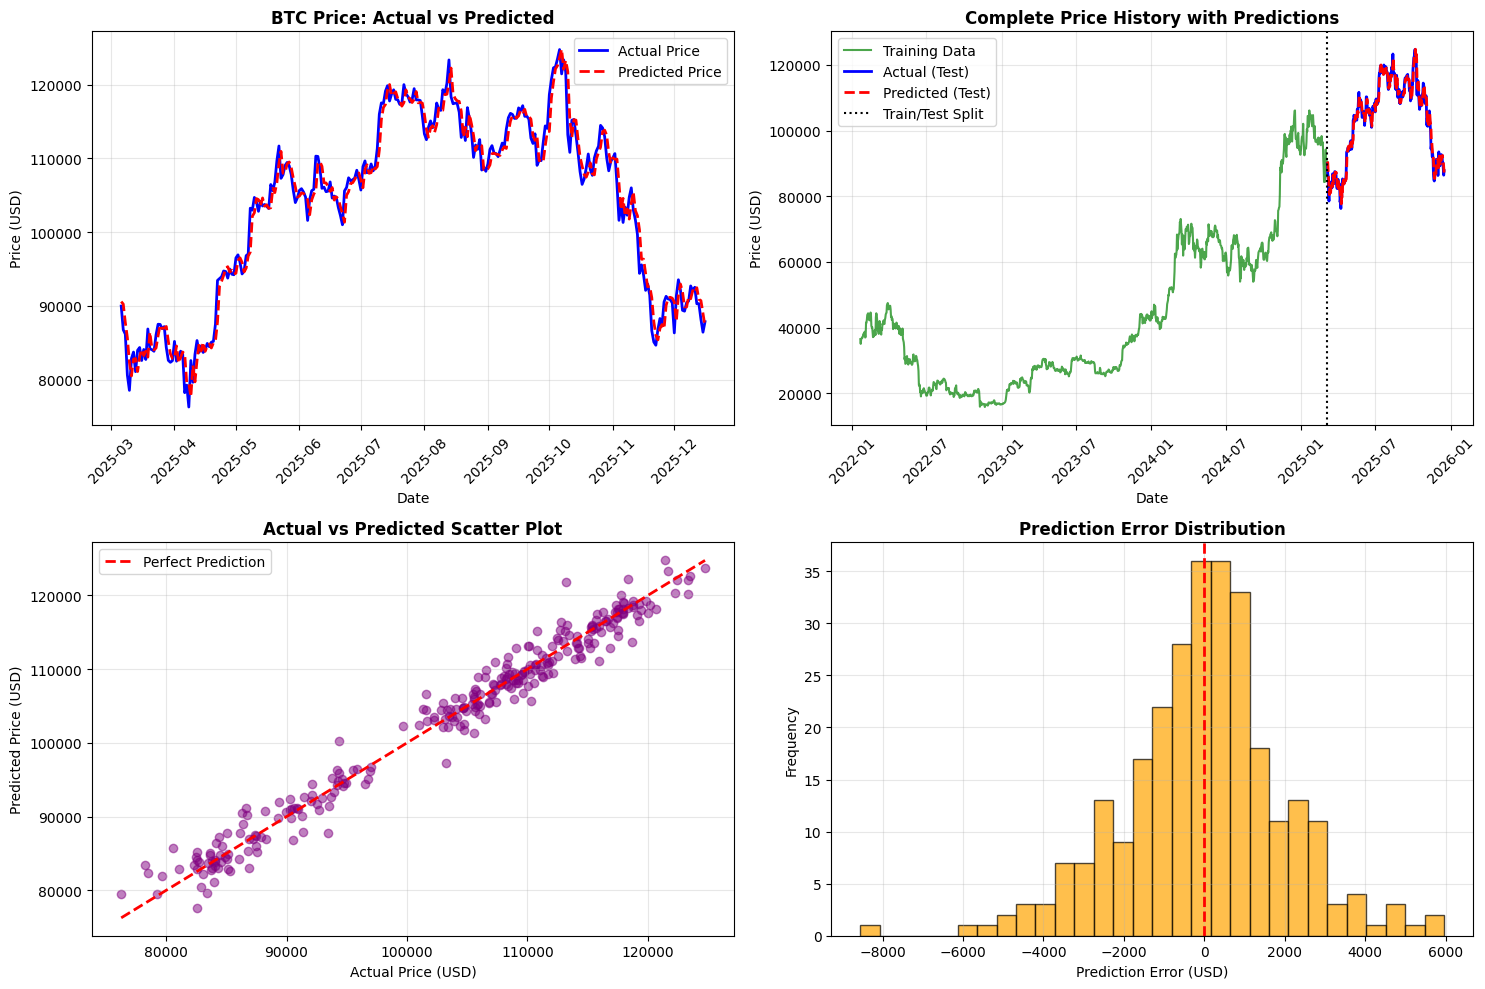


🔮 FUTURE PRICE PREDICTION (Next 7 Days)

Current BTC Price: $87,843.98
Date: 2025-12-16

Day 1 (2025-12-17): $88,784.15 📈 (+1.07%)
Day 2 (2025-12-18): $89,462.96 📈 (+1.84%)
Day 3 (2025-12-19): $89,953.24 📈 (+2.40%)
Day 4 (2025-12-20): $90,307.53 📈 (+2.80%)
Day 5 (2025-12-21): $90,563.71 📈 (+3.10%)
Day 6 (2025-12-22): $90,749.11 📈 (+3.31%)
Day 7 (2025-12-23): $90,890.49 📈 (+3.47%)

✅ Complete!


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# ============================================
# 1. FETCH BITCOIN DATA
# ============================================
print("📊 Fetching BTC data...")
btc = yf.download('BTC-USD', start='2022-01-01', end=datetime.now().strftime('%Y-%m-%d'))
print(f"✅ Downloaded {len(btc)} days of BTC data\n")

# ============================================
# FIX: Handle MultiIndex columns from yfinance
# ============================================
# Flatten column names if MultiIndex
if isinstance(btc.columns, pd.MultiIndex):
    btc.columns = btc.columns.get_level_values(0)
    print("✅ Fixed MultiIndex columns")

# Display first few rows
print(btc.head())
print(f"\nData shape: {btc.shape}")

# ============================================
# 2. FEATURE ENGINEERING
# ============================================
df = btc.copy()

# Create numeric day feature (days since start)
df['Day'] = np.arange(len(df))

# Moving Averages
df['MA_7'] = df['Close'].rolling(window=7).mean()
df['MA_21'] = df['Close'].rolling(window=21).mean()

# Lag features (previous prices)
df['Lag_1'] = df['Close'].shift(1)   # Yesterday's price
df['Lag_7'] = df['Close'].shift(7)   # Last week's price

# Price change
df['Price_Change'] = df['Close'].diff()

# Volatility (7-day standard deviation)
df['Volatility'] = df['Close'].rolling(window=7).std()

# Remove rows with NaN values
df.dropna(inplace=True)
print(f"\n✅ After feature engineering: {len(df)} samples")

# ============================================
# 3. PREPARE FEATURES AND TARGET
# ============================================
feature_columns = ['Day', 'MA_7', 'MA_21', 'Lag_1', 'Lag_7', 'Volatility', 'Volume']

X = df[feature_columns]
y = df['Close']

# FIX: Ensure y is 1D array
y = y.values.ravel()

print(f"\nFeatures used: {feature_columns}")

# ============================================
# 4. TRAIN/TEST SPLIT
# ============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=False
)

print(f"\n📈 Training samples: {len(X_train)}")
print(f"📉 Testing samples: {len(X_test)}")

# ============================================
# 5. CREATE AND TRAIN MODEL
# ============================================
model = LinearRegression()
model.fit(X_train, y_train)
print("\n✅ Model trained successfully!")

# ============================================
# 6. MAKE PREDICTIONS
# ============================================
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# ============================================
# 7. EVALUATE MODEL
# ============================================
print("\n" + "="*50)
print("📊 MODEL EVALUATION")
print("="*50)

# Training metrics
train_r2 = r2_score(y_train, y_pred_train)
print(f"\n🔵 Training R² Score: {train_r2:.4f}")

# Testing metrics
test_mse = mean_squared_error(y_test, y_pred_test)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print(f"\n🟢 Testing Metrics:")
print(f"   • R² Score: {test_r2:.4f}")
print(f"   • RMSE: ${test_rmse:,.2f}")
print(f"   • MAE: ${test_mae:,.2f}")

# Calculate MAPE
mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
print(f"   • MAPE: {mape:.2f}%")

# ============================================
# 8. FEATURE IMPORTANCE (COEFFICIENTS)
# ============================================
print("\n" + "="*50)
print("📊 FEATURE COEFFICIENTS")
print("="*50)

# FIX: Flatten coefficients properly
coef_values = model.coef_.flatten() if model.coef_.ndim > 1 else model.coef_

coefficients = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': coef_values
})
coefficients['Abs_Coefficient'] = np.abs(coefficients['Coefficient'])
coefficients = coefficients.sort_values('Abs_Coefficient', ascending=False)
print(coefficients.to_string(index=False))

# FIX: Handle intercept as array or scalar
intercept = model.intercept_
if isinstance(intercept, np.ndarray):
    intercept = float(intercept.flatten()[0])
else:
    intercept = float(intercept)
print(f"\nIntercept: ${intercept:,.2f}")

# ============================================
# 9. VISUALIZATIONS
# ============================================
# Get test dates for plotting
test_dates = df.index[-len(y_test):]
train_dates = df.index[:len(y_train)]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Subplot 1: Price Prediction
ax1 = axes[0, 0]
ax1.plot(test_dates, y_test, label='Actual Price', color='blue', linewidth=2)
ax1.plot(test_dates, y_pred_test, label='Predicted Price', color='red',
         linestyle='--', linewidth=2)
ax1.set_title('BTC Price: Actual vs Predicted', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price (USD)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Subplot 2: Full History with Prediction
ax2 = axes[0, 1]
ax2.plot(train_dates, y_train, label='Training Data', color='green', alpha=0.7)
ax2.plot(test_dates, y_test, label='Actual (Test)', color='blue', linewidth=2)
ax2.plot(test_dates, y_pred_test, label='Predicted (Test)', color='red',
         linestyle='--', linewidth=2)
ax2.axvline(x=test_dates[0], color='black', linestyle=':', label='Train/Test Split')
ax2.set_title('Complete Price History with Predictions', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price (USD)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Subplot 3: Scatter Plot
ax3 = axes[1, 0]
ax3.scatter(y_test, y_pred_test, alpha=0.5, color='purple')
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', linewidth=2, label='Perfect Prediction')
ax3.set_title('Actual vs Predicted Scatter Plot', fontsize=12, fontweight='bold')
ax3.set_xlabel('Actual Price (USD)')
ax3.set_ylabel('Predicted Price (USD)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Subplot 4: Prediction Error Distribution
ax4 = axes[1, 1]
errors = y_test - y_pred_test
ax4.hist(errors, bins=30, color='orange', edgecolor='black', alpha=0.7)
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax4.set_title('Prediction Error Distribution', fontsize=12, fontweight='bold')
ax4.set_xlabel('Prediction Error (USD)')
ax4.set_ylabel('Frequency')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('btc_prediction_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# 10. PREDICT FUTURE PRICES
# ============================================
print("\n" + "="*50)
print("🔮 FUTURE PRICE PREDICTION (Next 7 Days)")
print("="*50)

# Get last known values
last_close = float(df['Close'].iloc[-1])
last_ma7 = float(df['MA_7'].iloc[-1])
last_ma21 = float(df['MA_21'].iloc[-1])
last_volatility = float(df['Volatility'].iloc[-1])
last_volume = float(df['Volume'].iloc[-1])
last_day = int(df['Day'].iloc[-1])

# Store predictions
predicted_prices = [last_close]

print(f"\nCurrent BTC Price: ${last_close:,.2f}")
print(f"Date: {df.index[-1].strftime('%Y-%m-%d')}\n")

for i in range(1, 8):
    next_day = last_day + i

    future_features = pd.DataFrame({
        'Day': [next_day],
        'MA_7': [np.mean(predicted_prices[-7:]) if len(predicted_prices) >= 7 else last_ma7],
        'MA_21': [last_ma21],
        'Lag_1': [predicted_prices[-1]],
        'Lag_7': [predicted_prices[-7] if len(predicted_prices) >= 7 else last_close],
        'Volatility': [last_volatility],
        'Volume': [last_volume]
    })

    predicted_price = float(model.predict(future_features)[0])
    predicted_prices.append(predicted_price)

    future_date = df.index[-1] + timedelta(days=i)
    change = ((predicted_price - last_close) / last_close) * 100
    arrow = "📈" if predicted_price > predicted_prices[-2] else "📉"

    print(f"Day {i} ({future_date.strftime('%Y-%m-%d')}): ${predicted_price:,.2f} {arrow} ({change:+.2f}%)")

print("\n✅ Complete!")

In [3]:
from sklearn.tree import DecisionTreeRegressor

In [5]:
DT_model = DecisionTreeRegressor(random_state=42)
DT_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)


📊 MODEL EVALUATION

🔵 Training R² Score: 1.0000

🟢 Testing Metrics:
   • R² Score: 0.4582
   • RMSE: $9,057.65
   • MAE: $7,459.92
   • MAPE: 7.16%


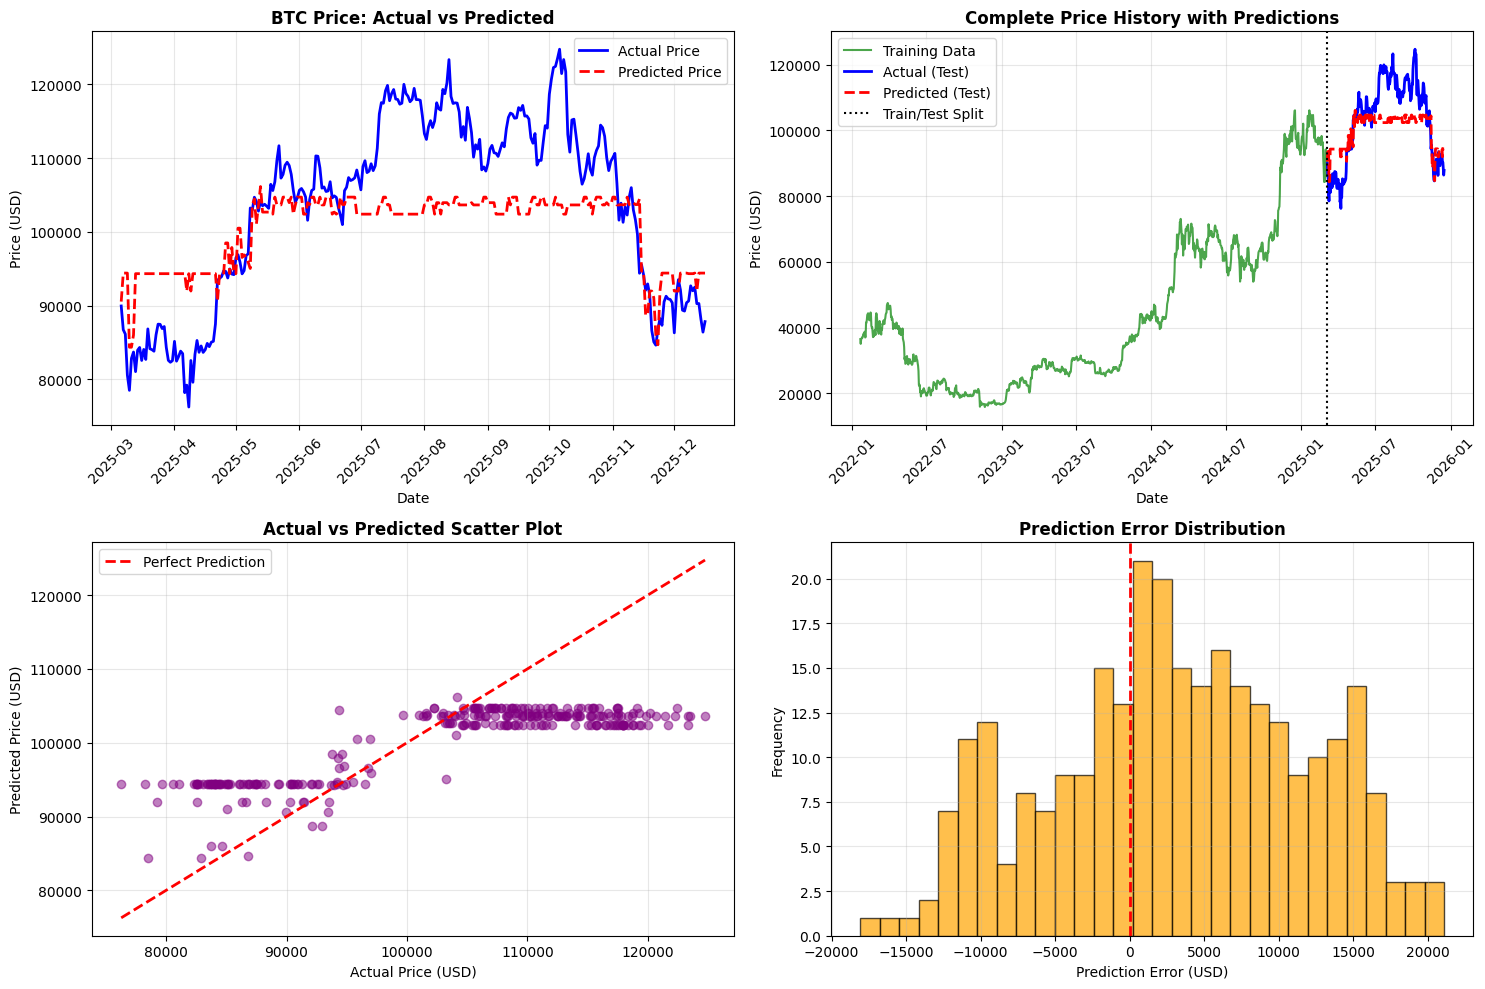


🔮 FUTURE PRICE PREDICTION (Next 7 Days)

Current BTC Price: $87,843.98
Date: 2025-12-16

Day 1 (2025-12-17): $94,419.76 📈 (+7.49%)
Day 2 (2025-12-18): $98,504.73 📈 (+12.14%)
Day 3 (2025-12-19): $100,504.49 📈 (+14.41%)
Day 4 (2025-12-20): $99,756.91 📉 (+13.56%)
Day 5 (2025-12-21): $99,756.91 📉 (+13.56%)
Day 6 (2025-12-22): $99,756.91 📉 (+13.56%)
Day 7 (2025-12-23): $99,756.91 📉 (+13.56%)

✅ Complete!


In [10]:
y_pred_train = DT_model.predict(X_train)
y_pred_test = DT_model.predict(X_test)

# ============================================
# 7. EVALUATE MODEL
# ============================================
print("\n" + "="*50)
print("📊 MODEL EVALUATION")
print("="*50)

# Training metrics
train_r2 = r2_score(y_train, y_pred_train)
print(f"\n🔵 Training R² Score: {train_r2:.4f}")

# Testing metrics
test_mse = mean_squared_error(y_test, y_pred_test)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print(f"\n🟢 Testing Metrics:")
print(f"   • R² Score: {test_r2:.4f}")
print(f"   • RMSE: ${test_rmse:,.2f}")
print(f"   • MAE: ${test_mae:,.2f}")

# Calculate MAPE
mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
print(f"   • MAPE: {mape:.2f}%")

# 9. VISUALIZATIONS
# ============================================
# Get test dates for plotting
test_dates = df.index[-len(y_test):]
train_dates = df.index[:len(y_train)]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Subplot 1: Price Prediction
ax1 = axes[0, 0]
ax1.plot(test_dates, y_test, label='Actual Price', color='blue', linewidth=2)
ax1.plot(test_dates, y_pred_test, label='Predicted Price', color='red',
         linestyle='--', linewidth=2)
ax1.set_title('BTC Price: Actual vs Predicted', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price (USD)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Subplot 2: Full History with Prediction
ax2 = axes[0, 1]
ax2.plot(train_dates, y_train, label='Training Data', color='green', alpha=0.7)
ax2.plot(test_dates, y_test, label='Actual (Test)', color='blue', linewidth=2)
ax2.plot(test_dates, y_pred_test, label='Predicted (Test)', color='red',
         linestyle='--', linewidth=2)
ax2.axvline(x=test_dates[0], color='black', linestyle=':', label='Train/Test Split')
ax2.set_title('Complete Price History with Predictions', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price (USD)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Subplot 3: Scatter Plot
ax3 = axes[1, 0]
ax3.scatter(y_test, y_pred_test, alpha=0.5, color='purple')
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', linewidth=2, label='Perfect Prediction')
ax3.set_title('Actual vs Predicted Scatter Plot', fontsize=12, fontweight='bold')
ax3.set_xlabel('Actual Price (USD)')
ax3.set_ylabel('Predicted Price (USD)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Subplot 4: Prediction Error Distribution
ax4 = axes[1, 1]
errors = y_test - y_pred_test
ax4.hist(errors, bins=30, color='orange', edgecolor='black', alpha=0.7)
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax4.set_title('Prediction Error Distribution', fontsize=12, fontweight='bold')
ax4.set_xlabel('Prediction Error (USD)')
ax4.set_ylabel('Frequency')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('btc_prediction_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# 10. PREDICT FUTURE PRICES
# ============================================
print("\n" + "="*50)
print("🔮 FUTURE PRICE PREDICTION (Next 7 Days)")
print("="*50)

# Get last known values
last_close = float(df['Close'].iloc[-1])
last_ma7 = float(df['MA_7'].iloc[-1])
last_ma21 = float(df['MA_21'].iloc[-1])
last_volatility = float(df['Volatility'].iloc[-1])
last_volume = float(df['Volume'].iloc[-1])
last_day = int(df['Day'].iloc[-1])

# Store predictions
predicted_prices = [last_close]

print(f"\nCurrent BTC Price: ${last_close:,.2f}")
print(f"Date: {df.index[-1].strftime('%Y-%m-%d')}\n")

for i in range(1, 8):
    next_day = last_day + i

    future_features = pd.DataFrame({
        'Day': [next_day],
        'MA_7': [np.mean(predicted_prices[-7:]) if len(predicted_prices) >= 7 else last_ma7],
        'MA_21': [last_ma21],
        'Lag_1': [predicted_prices[-1]],
        'Lag_7': [predicted_prices[-7] if len(predicted_prices) >= 7 else last_close],
        'Volatility': [last_volatility],
        'Volume': [last_volume]
    })

    predicted_price = float(DT_model.predict(future_features)[0])
    predicted_prices.append(predicted_price)

    future_date = df.index[-1] + timedelta(days=i)
    change = ((predicted_price - last_close) / last_close) * 100
    arrow = "📈" if predicted_price > predicted_prices[-2] else "📉"

    print(f"Day {i} ({future_date.strftime('%Y-%m-%d')}): ${predicted_price:,.2f} {arrow} ({change:+.2f}%)")

print("\n✅ Complete!")


🌲 Training Random Forest Regressor...
✅ Random Forest model trained successfully!

📊 RANDOM FOREST MODEL EVALUATION

🔵 Training R² Score: 0.9989

🟢 Testing Metrics:
   • R² Score: 0.1935
   • RMSE: $11,051.60
   • MAE: $9,129.45
   • MAPE: 8.42%

📊 FEATURE IMPORTANCE (Random Forest)
   Feature  Importance
      MA_7    0.285818
       Day    0.257242
     Lag_1    0.189892
     MA_21    0.155837
     Lag_7    0.085495
Volatility    0.022150
    Volume    0.003567


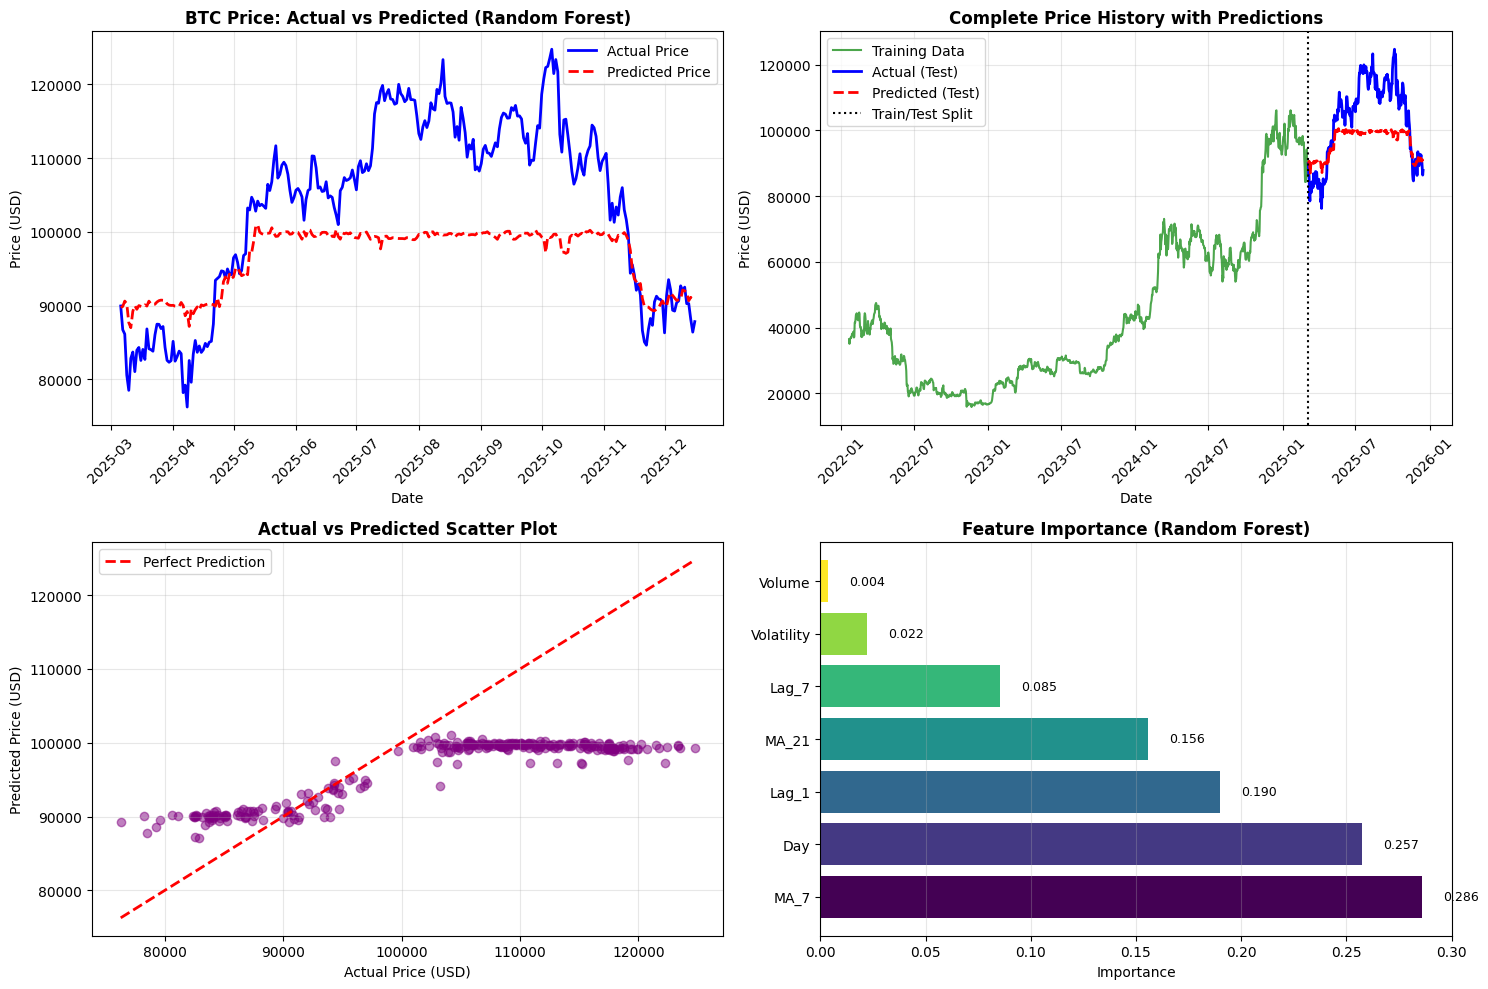


🔮 FUTURE PRICE PREDICTION (Next 7 Days)

Current BTC Price: $87,843.98
Date: 2025-12-16

Day 1 (2025-12-17): $90,630.67 📈 (+3.17%)
Day 2 (2025-12-18): $90,700.54 📈 (+3.25%)
Day 3 (2025-12-19): $90,700.54 📉 (+3.25%)
Day 4 (2025-12-20): $90,700.54 📉 (+3.25%)
Day 5 (2025-12-21): $90,700.54 📉 (+3.25%)
Day 6 (2025-12-22): $90,700.54 📉 (+3.25%)
Day 7 (2025-12-23): $90,818.02 📈 (+3.39%)

✅ Complete!


In [12]:

from sklearn.ensemble import RandomForestRegressor  # ← CHANGED


# ============================================
# 5. CREATE AND TRAIN RANDOM FOREST MODEL   ← CHANGED
# ============================================
print("\n🌲 Training Random Forest Regressor...")

model = RandomForestRegressor(
    n_estimators=100,        # Number of trees in the forest
    max_depth=10,            # Maximum depth of each tree
    min_samples_split=5,     # Minimum samples to split a node
    min_samples_leaf=2,      # Minimum samples in a leaf node
    max_features='sqrt',     # Number of features for best split
    random_state=42,         # For reproducibility
    n_jobs=-1                # Use all CPU cores
)

model.fit(X_train, y_train)
print("✅ Random Forest model trained successfully!")

# ============================================
# 6. MAKE PREDICTIONS
# ============================================
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# ============================================
# 7. EVALUATE MODEL
# ============================================
print("\n" + "="*50)
print("📊 RANDOM FOREST MODEL EVALUATION")
print("="*50)

# Training metrics
train_r2 = r2_score(y_train, y_pred_train)
print(f"\n🔵 Training R² Score: {train_r2:.4f}")

# Testing metrics
test_mse = mean_squared_error(y_test, y_pred_test)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print(f"\n🟢 Testing Metrics:")
print(f"   • R² Score: {test_r2:.4f}")
print(f"   • RMSE: ${test_rmse:,.2f}")
print(f"   • MAE: ${test_mae:,.2f}")

# Calculate MAPE
mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
print(f"   • MAPE: {mape:.2f}%")

# ============================================
# 8. FEATURE IMPORTANCE                      ← CHANGED
# ============================================
print("\n" + "="*50)
print("📊 FEATURE IMPORTANCE (Random Forest)")
print("="*50)

# Random Forest uses feature_importances_ instead of coef_
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print(feature_importance.to_string(index=False))

# Note: Random Forest doesn't have an intercept like Linear Regression

# ============================================
# 9. VISUALIZATIONS
# ============================================
test_dates = df.index[-len(y_test):]
train_dates = df.index[:len(y_train)]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Subplot 1: Price Prediction
ax1 = axes[0, 0]
ax1.plot(test_dates, y_test, label='Actual Price', color='blue', linewidth=2)
ax1.plot(test_dates, y_pred_test, label='Predicted Price', color='red',
         linestyle='--', linewidth=2)
ax1.set_title('BTC Price: Actual vs Predicted (Random Forest)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price (USD)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Subplot 2: Full History with Prediction
ax2 = axes[0, 1]
ax2.plot(train_dates, y_train, label='Training Data', color='green', alpha=0.7)
ax2.plot(test_dates, y_test, label='Actual (Test)', color='blue', linewidth=2)
ax2.plot(test_dates, y_pred_test, label='Predicted (Test)', color='red',
         linestyle='--', linewidth=2)
ax2.axvline(x=test_dates[0], color='black', linestyle=':', label='Train/Test Split')
ax2.set_title('Complete Price History with Predictions', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price (USD)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Subplot 3: Scatter Plot
ax3 = axes[1, 0]
ax3.scatter(y_test, y_pred_test, alpha=0.5, color='purple')
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', linewidth=2, label='Perfect Prediction')
ax3.set_title('Actual vs Predicted Scatter Plot', fontsize=12, fontweight='bold')
ax3.set_xlabel('Actual Price (USD)')
ax3.set_ylabel('Predicted Price (USD)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Subplot 4: Feature Importance Bar Chart     ← CHANGED
ax4 = axes[1, 1]
colors = plt.cm.viridis(np.linspace(0, 1, len(feature_importance)))
bars = ax4.barh(feature_importance['Feature'], feature_importance['Importance'], color=colors)
ax4.set_title('Feature Importance (Random Forest)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Importance')
ax4.grid(True, alpha=0.3, axis='x')
# Add value labels
for bar, val in zip(bars, feature_importance['Importance']):
    ax4.text(val + 0.01, bar.get_y() + bar.get_height()/2,
             f'{val:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('btc_rf_prediction_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# 10. PREDICT FUTURE PRICES
# ============================================
print("\n" + "="*50)
print("🔮 FUTURE PRICE PREDICTION (Next 7 Days)")
print("="*50)

last_close = float(df['Close'].iloc[-1])
last_ma7 = float(df['MA_7'].iloc[-1])
last_ma21 = float(df['MA_21'].iloc[-1])
last_volatility = float(df['Volatility'].iloc[-1])
last_volume = float(df['Volume'].iloc[-1])
last_day = int(df['Day'].iloc[-1])

predicted_prices = [last_close]

print(f"\nCurrent BTC Price: ${last_close:,.2f}")
print(f"Date: {df.index[-1].strftime('%Y-%m-%d')}\n")

for i in range(1, 8):
    next_day = last_day + i

    future_features = pd.DataFrame({
        'Day': [next_day],
        'MA_7': [np.mean(predicted_prices[-7:]) if len(predicted_prices) >= 7 else last_ma7],
        'MA_21': [last_ma21],
        'Lag_1': [predicted_prices[-1]],
        'Lag_7': [predicted_prices[-7] if len(predicted_prices) >= 7 else last_close],
        'Volatility': [last_volatility],
        'Volume': [last_volume]
    })

    predicted_price = float(model.predict(future_features)[0])
    predicted_prices.append(predicted_price)

    future_date = df.index[-1] + timedelta(days=i)
    change = ((predicted_price - last_close) / last_close) * 100
    arrow = "📈" if predicted_price > predicted_prices[-2] else "📉"

    print(f"Day {i} ({future_date.strftime('%Y-%m-%d')}): ${predicted_price:,.2f} {arrow} ({change:+.2f}%)")

print("\n✅ Complete!")